# Theoretical PC energy of deep linear networks

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/linear_net_theoretical_energy.ipynb)

This notebook demonstrates how to compute the theoretical PC energy at the inference equilibrium $\mathcal{F}^*$ when $\nabla_{\mathbf{z}} \mathcal{F} = \mathbf{0}$ for deep linear networks ([Innocenti et al., 2024](https://papers.nips.cc/paper_files/paper/2024/hash/6075fc6540b9a3cb951752099efd86ef-Abstract-Conference.html)). For a set of inputs and outputs $\{(\mathbf{x}_i, \mathbf{y}_i)\}_{i=1}^N$, this is given by 

\begin{equation}
    \mathcal{F}^* = \frac{1}{2N} \sum_{i=1}^N (\mathbf{y}_i - \mathbf{W}_{L:1}\mathbf{x}_i)^T \mathbf{S}^{-1}(\mathbf{y}_i - \mathbf{W}_{L:1}\mathbf{x}_i)
\end{equation}

where $\mathbf{S} = \mathbf{I}_{d_y} + \sum_{\ell=2}^L (\mathbf{W}_{L:\ell})(\mathbf{W}_{L:\ell})^T$ and $\mathbf{W}_{k:\ell} = \mathbf{W}_k \dots \mathbf{W}_\ell$ for $\ell, k \in 1,\dots, L$. This result can be generalised to any linear layer transformation $\mathbf{B}_\ell$, e.g. for a ResNet $\mathbf{B}_\ell = \mathbf{I} + \mathbf{W}_\ell$ (see [Innocenti et al., 2025](https://openreview.net/forum?id=lSLSzYuyfX&referrer=%5Bthe%20profile%20of%20Francesco%20Innocenti%5D(%2Fprofile%3Fid%3D~Francesco_Innocenti1))).


In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install plotly==5.11.0
!pip install -U kaleido

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including the network architecture, learning rate, batch size, etc.

In [3]:
SEED = 0

INPUT_DIM = 784
WIDTH = 300
DEPTH = 5
OUTPUT_DIM = 10
ACT_FN = "linear"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_T1 = 300
TEST_EVERY = 10
N_TRAIN_ITERS = 100

## Dataset

Some utils to fetch MNIST.

In [4]:
def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]
    

## Plotting

In [5]:
def plot_total_energies(energies):
    n_train_iters = len(energies["theory"])
    train_iters = [b+1 for b in range(n_train_iters)]
    
    _, ax = plt.subplots(figsize=(6, 3))
    
    for energy_type, energy in energies.items():
        is_theory = energy_type == "theory"
        line_style = "--" if is_theory else "-"
        color = "black" if is_theory else "#00CC96"  #"rgb(27, 158, 119)"
        
        if color.startswith("rgb"):
            rgb = tuple(int(x)/255 for x in color[4:-1].split(","))
        else:
            rgb = color
    
        ax.plot(
            train_iters, 
            energy, 
            label=energy_type, 
            linewidth=3 if is_theory else 2,
            linestyle=line_style,
            color=rgb
        )
    
    ax.legend(fontsize=16)
    ax.set_xlabel("Training Iteration", fontsize=18, labelpad=10)
    ax.set_ylabel("Energy", fontsize=18, labelpad=10)
    ax.tick_params(axis='both', labelsize=14)
    plt.grid(True)
    plt.show()


## Train and test

To compute the theoretical energy, we can use [`jpc.linear_equilib_energy()`](https://thebuckleylab.github.io/jpc/api/Theoretical%20tools/#jpc.linear_equilib_energy) which as clear from the equation above just takes a linear network and some data.

In [6]:
def evaluate(model, test_loader):
    avg_test_loss, avg_test_acc = 0, 0
    for _, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        test_loss, test_acc = jpc.test_discriminative_pc(
            model=model,
            output=label_batch,
            input=img_batch
        )
        avg_test_loss += test_loss
        avg_test_acc += test_acc

    return avg_test_loss / len(test_loader), avg_test_acc / len(test_loader)


def train( 
      input_dim,
      width,
      depth,
      output_dim,
      act_fn,
      lr,
      batch_size,
      max_t1,
      test_every,
      n_train_iters
):
    key = jax.random.PRNGKey(0)

    # NOTE: act_fn is linear and we use no biases 
    model = jpc.make_mlp(
        key, 
        input_dim=input_dim,
        width=width,
        depth=depth,
        output_dim=output_dim,
        act_fn=act_fn,
        use_bias=False
    )
    optim = optax.adam(lr)
    opt_state = optim.init(
        (eqx.filter(model, eqx.is_array), None)
    )
    train_loader, test_loader = get_mnist_loaders(batch_size)

    num_total_energies, theory_total_energies = [], []
    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        theory_total_energies.append(
            jpc.linear_equilib_energy(
                model=model, 
                x=img_batch, 
                y=label_batch
            )
        )
        result = jpc.make_pc_step(
            model,
            optim,
            opt_state,
            output=label_batch,
            input=img_batch,
            max_t1=max_t1,
            record_energies=True
        )
        model, opt_state = result["model"], result["opt_state"]
        train_loss, t_max = result["loss"], result["t_max"]
        num_total_energies.append(result["energies"][:, t_max-1].sum())

        if ((iter+1) % test_every) == 0:
            _, avg_test_acc = evaluate(model, test_loader)
            print(
                f"Train iter {iter+1}, train loss={train_loss:4f}, "
                f"avg test accuracy={avg_test_acc:4f}"
            )
            if (iter+1) >= n_train_iters:
                break
    
    return {
        "theory": jnp.array(theory_total_energies),
        "experiment": jnp.array(num_total_energies)
    }


## Run

Below we plot the theoretical energy against the numerical one.

Train iter 10, train loss=0.027985, avg test accuracy=72.105370
Train iter 20, train loss=0.027246, avg test accuracy=80.458733
Train iter 30, train loss=0.024185, avg test accuracy=78.325317
Train iter 40, train loss=0.025714, avg test accuracy=82.381813
Train iter 50, train loss=0.025583, avg test accuracy=80.558891
Train iter 60, train loss=0.026662, avg test accuracy=79.837738
Train iter 70, train loss=0.026263, avg test accuracy=80.568909
Train iter 80, train loss=0.021536, avg test accuracy=79.597359
Train iter 90, train loss=0.026155, avg test accuracy=82.391830
Train iter 100, train loss=0.024597, avg test accuracy=77.724358


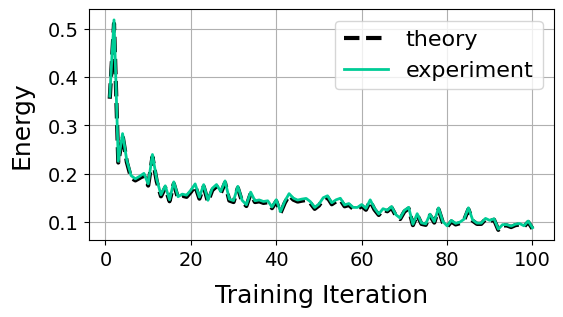

In [7]:
energies = train(
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    act_fn=ACT_FN,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    test_every=TEST_EVERY,
    max_t1=MAX_T1,
    n_train_iters=N_TRAIN_ITERS
)
plot_total_energies(energies)